In [1]:
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as pa
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the data

In [5]:
crsp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crsp_m_2000.csv')
crsp

,date,permno,prc,ret,shrout,vol
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0
...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0


Generating inputs necessary for the portfolio evaluation

In [6]:
crsp['relvol'] = 0.1*crsp.vol/crsp.shrout # trading vol per share
crsp['date'] = pd.to_datetime(crsp.date) # string to Timestamp
crsp['prc'] = crsp.prc.abs() # abs(prc). If there is not a close price, the mid price of bid and ask is used with a negative sign. Change them to a positive value.
crsp['size'] = np.log(crsp.prc * crsp.shrout) # log(market capitalization)
crsp['mcap'] = crsp.prc * crsp.shrout
crsp

,date,permno,prc,ret,shrout,vol,relvol,size,mcap
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,10.988018,5.916100e+04
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,10.970740,5.814762e+04
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,10.868197,5.248050e+04
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,10.833711,5.070150e+04
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,10.915023,5.499638e+04
...,...,...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,17.756336,5.146109e+07
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,17.631655,4.542871e+07
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,17.874728,5.792898e+07
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206,17.913000,6.018898e+07


Preprocessing the data

In [7]:
# remove nan's
crsp.dropna(inplace=True)
crsp.shape

# remove outliers (top/bottom 1%)
lb = crsp['ret'].quantile(q = 0.01)
ub = crsp['ret'].quantile(q = 0.99)

print(lb)
print(ub)

crsp = crsp[crsp.ret > lb]
crsp = crsp[crsp.ret < ub]


-0.466666668653488
0.6666666865348821


In [8]:
crsp = crsp.dropna()
crsp

,date,permno,prc,ret,shrout,vol,relvol,size,mcap
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,10.988018,5.916100e+04
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,10.970740,5.814762e+04
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,10.868197,5.248050e+04
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,10.833711,5.070150e+04
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,10.915023,5.499638e+04
...,...,...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,17.756336,5.146109e+07
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,17.631655,4.542871e+07
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,17.874728,5.792898e+07
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206,17.913000,6.018898e+07


Generating the list of stocks available to analyze

In [9]:
stocks_list = crsp['permno'].unique()
stocks_list

array([80000, 80001, 80002, ..., 93434, 93435, 93436])

Defining the function to calculate RSI for each stock. RSI stands for "Relative Strength Index." It is a technical indicator used by traders and investors to analyze the price momentum of a stock or other financial instruments. The RSI is displayed as a number between 0 and 100 and is used to identify overbought and oversold conditions in a stock. When the RSI value is above 70, it is considered overbought, suggesting that the stock may be due for a price correction or a potential reversal. Conversely, when the RSI value is below 30, it is considered oversold, indicating that the stock may be undervalued and a price rebound could be expected.

In [10]:
'''
Function to calculate rsi for a specific stock
@params:
- df : dataframe
- col_stock_name : name of column containing stock name in df
- stock_name : name of stock
- length : how many months considered for rsi

@return : Pandas Dataframe with "rsi" column added
'''
def get_rsi_3(df, col_stock_name, stock_name, length = 3):
    stock_df = df[df[col_stock_name] == stock_name]
    stock_df['rsi_3'] = pa.rsi(close = stock_df.prc, length = length)
    return stock_df

def get_rsi_6(df, col_stock_name, stock_name, length = 6):
    stock_df = df[df[col_stock_name] == stock_name]
    stock_df['rsi_6'] = pa.rsi(close = stock_df.prc, length = length)
    return stock_df

def get_rsi_9(df, col_stock_name, stock_name, length = 9):
    stock_df = df[df[col_stock_name] == stock_name]
    stock_df['rsi_9'] = pa.rsi(close = stock_df.prc, length = length)
    return stock_df

In [11]:
'''
Function to calculate rsi for dataframe
@params:
- df : dataframe
- col_stock_name : name of column containing stock name in df
- length : how many months considered for rsi

@return : Pandas Dataframe with "rsi" column added
'''
def add_rsi_df_3(df,col_stock_name, length):
    data_aug = []
    stocks_list = df[col_stock_name].unique()

    for stock in tqdm(stocks_list):
        stock_rsi = get_rsi_3(df, col_stock_name, stock, 3) #get rsi

        if len(data_aug) == 0 : data_aug = stock_rsi.copy()
        else : #append to get all stocks
            data_aug = data_aug.append(stock_rsi, ignore_index=False)

    return data_aug

def add_rsi_df_6(df,col_stock_name, length):
    data_aug = []
    stocks_list = df[col_stock_name].unique()

    for stock in tqdm(stocks_list):
        stock_rsi = get_rsi_6(df, col_stock_name, stock, 6) #get rsi

        if len(data_aug) == 0 : data_aug = stock_rsi.copy()
        else : #append to get all stocks
            data_aug = data_aug.append(stock_rsi, ignore_index=False)

    return data_aug

def add_rsi_df_9(df,col_stock_name, length):
    data_aug = []
    stocks_list = df[col_stock_name].unique()

    for stock in tqdm(stocks_list):
        stock_rsi = get_rsi_9(df, col_stock_name, stock, 9) #get rsi

        if len(data_aug) == 0 : data_aug = stock_rsi.copy()
        else : #append to get all stocks
            data_aug = data_aug.append(stock_rsi, ignore_index=False)

    return data_aug

Applying the functions to the dataframe

In [12]:
data_rsi = add_rsi_df_3(crsp, 'permno', 3)

100%|██████████| 6452/6452 [01:40<00:00, 64.22it/s]


In [13]:
data_rsi = add_rsi_df_6(data_rsi, 'permno', 6)

100%|██████████| 6452/6452 [01:30<00:00, 70.92it/s]


In [14]:
data_rsi = add_rsi_df_9(data_rsi, 'permno', 9)

100%|██████████| 6452/6452 [01:35<00:00, 67.48it/s]


In [15]:
data_rsi

,date,permno,prc,ret,shrout,vol,relvol,size,mcap,rsi_3,rsi_6,rsi_9
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,10.988018,5.916100e+04,NaN,NaN,NaN
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,10.970740,5.814762e+04,NaN,NaN,NaN
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,10.868197,5.248050e+04,NaN,NaN,NaN
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,10.833711,5.070150e+04,0.000000,NaN,NaN
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,10.915023,5.499638e+04,49.090909,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,17.756336,5.146109e+07,45.862005,47.818631,49.710485
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,17.631655,4.542871e+07,27.493292,38.064726,42.604283
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,17.874728,5.792898e+07,66.763406,58.190929,56.395488
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206,17.913000,6.018898e+07,71.032234,60.952860,58.433636


Defining the function to calculate SMA. SMA stands for "Simple Moving Average." It is a commonly used technical analysis tool in the stock market and other financial markets. The SMA calculates the average price of a stock or other financial instrument over a specific time period by adding the closing prices for that period and dividing the sum by the number of periods.

In [16]:
'''
Function to calculate sma for a specific stock
@params:
- df : dataframe
- col_stock_name : name of column containing stock name in df
- stock_name : name of stock
- length : how many months considered for sma

@return : Pandas Dataframe with "sma" column added
'''
def get_sma_3(df, col_stock_name, stock_name, length = 3):
    stock_df = df[df[col_stock_name] == stock_name]
    stock_df['sma_3'] = pa.sma(close = stock_df.prc, length = length)
    return stock_df

def get_sma_6(df, col_stock_name, stock_name, length = 6):
    stock_df = df[df[col_stock_name] == stock_name]
    stock_df['sma_6'] = pa.sma(close = stock_df.prc, length = length)
    return stock_df

def get_sma_9(df, col_stock_name, stock_name, length = 9):
    stock_df = df[df[col_stock_name] == stock_name]
    stock_df['sma_9'] = pa.sma(close = stock_df.prc, length = length)
    return stock_df

In [17]:
'''
Function to calculate sma for dataframe
@params:
- df : dataframe
- col_stock_name : name of column containing stock name in df
- length : how many months considered for sma

@return : Pandas Dataframe with "sma" column added
'''
def add_sma_df_3(df,col_stock_name, length):
    data_aug = []
    stocks_list = df[col_stock_name].unique()

    for stock in tqdm(stocks_list):
        stock_sma = get_sma_3(df, col_stock_name, stock, 3) #get sma

        if len(data_aug) == 0 : data_aug = stock_sma.copy()
        else : #append to get all stocks
            data_aug = data_aug.append(stock_sma, ignore_index=False)

    return data_aug

def add_sma_df_6(df,col_stock_name, length):
    data_aug = []
    stocks_list = df[col_stock_name].unique()

    for stock in tqdm(stocks_list):
        stock_sma = get_sma_6(df, col_stock_name, stock, 6) #get sma

        if len(data_aug) == 0 : data_aug = stock_sma.copy()
        else : #append to get all stocks
            data_aug = data_aug.append(stock_sma, ignore_index=False)

    return data_aug

def add_sma_df_9(df,col_stock_name, length):
    data_aug = []
    stocks_list = df[col_stock_name].unique()

    for stock in tqdm(stocks_list):
        stock_sma = get_sma_9(df, col_stock_name, stock, 9) #get sma

        if len(data_aug) == 0 : data_aug = stock_sma.copy()
        else : #append to get all stocks
            data_aug = data_aug.append(stock_sma, ignore_index=False)

    return data_aug

In [18]:
data_sma = add_sma_df_3(data_rsi, 'permno', 3)

100%|██████████| 6452/6452 [01:16<00:00, 84.20it/s]


In [19]:
data_sma = add_sma_df_6(data_sma, 'permno', 6)

100%|██████████| 6452/6452 [01:23<00:00, 77.51it/s]


In [20]:
data_sma = add_sma_df_9(data_sma, 'permno', 9)

100%|██████████| 6452/6452 [01:30<00:00, 70.93it/s]


In [21]:
df = data_sma.copy()
df

,date,permno,prc,ret,shrout,vol,relvol,size,mcap,rsi_3,rsi_6,rsi_9,sma_3,sma_6,sma_9
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,10.988018,5.916100e+04,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,10.970740,5.814762e+04,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,10.868197,5.248050e+04,NaN,NaN,NaN,15.958333,NaN,NaN
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,10.833711,5.070150e+04,0.000000,NaN,NaN,15.125000,NaN,NaN
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,10.915023,5.499638e+04,49.090909,NaN,NaN,14.791667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,17.756336,5.146109e+07,45.862005,47.818631,49.710485,314.250010,297.918340,310.692227
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,17.631655,4.542871e+07,27.493292,38.064726,42.604283,288.190002,297.691671,305.516669
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,17.874728,5.792898e+07,66.763406,58.190929,56.395488,301.250000,304.928340,303.628893
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206,17.913000,6.018898e+07,71.032234,60.952860,58.433636,317.523336,315.886673,304.453339


We define the target return is the return 9 months from now to match with the goal of predicting the RSI index of each stock 9 months from now.

In [22]:
df['tgt_ret'] = df.groupby('permno')['ret'].shift(-9)
df

,date,permno,prc,ret,shrout,vol,relvol,size,mcap,rsi_3,rsi_6,rsi_9,sma_3,sma_6,sma_9,tgt_ret
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,10.988018,5.916100e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.115942
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,10.970740,5.814762e+04,NaN,NaN,NaN,NaN,NaN,NaN,-0.032468
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,10.868197,5.248050e+04,NaN,NaN,NaN,15.958333,NaN,NaN,0.053691
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,10.833711,5.070150e+04,0.000000,NaN,NaN,15.125000,NaN,NaN,0.025478
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,10.915023,5.499638e+04,49.090909,NaN,NaN,14.791667,NaN,NaN,-0.003106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,17.756336,5.146109e+07,45.862005,47.818631,49.710485,314.250010,297.918340,310.692227,NaN
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,17.631655,4.542871e+07,27.493292,38.064726,42.604283,288.190002,297.691671,305.516669,NaN
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,17.874728,5.792898e+07,66.763406,58.190929,56.395488,301.250000,304.928340,303.628893,NaN
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206,17.913000,6.018898e+07,71.032234,60.952860,58.433636,317.523336,315.886673,304.453339,NaN


Making sure all of our inputs are in the data type as float for analysis

In [23]:
df['rsi_3'] = df['rsi_3'].astype(float)
df['rsi_6'] = df['rsi_6'].astype(float)
df['rsi_9'] = df['rsi_9'].astype(float)
df['sma_3'] = df['sma_3'].astype(float)
df['sma_6'] = df['sma_6'].astype(float)
df['sma_9'] = df['sma_9'].astype(float)
df

,date,permno,prc,ret,shrout,vol,relvol,size,mcap,rsi_3,rsi_6,rsi_9,sma_3,sma_6,sma_9,tgt_ret
0,2000-01-31,80000,16.750000,-0.007407,3532.0,1547.0,0.043800,10.988018,5.916100e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.115942
1,2000-02-29,80000,16.375000,-0.022388,3551.0,2394.0,0.067418,10.970740,5.814762e+04,NaN,NaN,NaN,NaN,NaN,NaN,-0.032468
2,2000-03-31,80000,14.750000,-0.099237,3558.0,2430.0,0.068297,10.868197,5.248050e+04,NaN,NaN,NaN,15.958333,NaN,NaN,0.053691
3,2000-04-28,80000,14.250000,-0.033898,3558.0,2122.0,0.059640,10.833711,5.070150e+04,0.000000,NaN,NaN,15.125000,NaN,NaN,0.025478
4,2000-05-31,80000,15.375000,0.078947,3577.0,1841.0,0.051468,10.915023,5.499638e+04,49.090909,NaN,NaN,14.791667,NaN,NaN,-0.003106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,17.756336,5.146109e+07,45.862005,47.818631,49.710485,314.250010,297.918340,310.692227,NaN
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,17.631655,4.542871e+07,27.493292,38.064726,42.604283,288.190002,297.691671,305.516669,NaN
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,17.874728,5.792898e+07,66.763406,58.190929,56.395488,301.250000,304.928340,303.628893,NaN
609245,2018-11-30,93436,350.480011,0.039013,171733.0,1331285.0,0.775206,17.913000,6.018898e+07,71.032234,60.952860,58.433636,317.523336,315.886673,304.453339,NaN


# Label

The value 0 indicates the stock will be most overbought in the upcoming 9 months. This means that the asset is potentially overvalued, so traders and investors may interpret this as a signal to consider selling or taking profits. And the other way around for value 9.

In [24]:
df = df.dropna()

As RSI > 70 indicates overbought, and RSI < 30 indicates oversold, it is best to quantile our lable of 7 levels.

In [25]:
df['signal'] = df.groupby('date')['rsi_9'].transform(lambda x: pd.qcut(-x, 7, labels=False))
df

,date,permno,prc,ret,shrout,vol,relvol,size,mcap,rsi_3,rsi_6,rsi_9,sma_3,sma_6,sma_9,tgt_ret,signal
9,2000-10-31,80000,19.250000,0.115942,3581.0,1668.0,0.046579,11.140908,6.893425e+04,88.095709,77.053086,72.670357,17.833333,16.958333,16.347222,0.035377,0
10,2000-11-30,80000,18.625000,-0.032468,3563.0,1222.0,0.034297,11.102863,6.636088e+04,69.350665,67.489678,65.366747,18.375000,17.500000,16.597222,0.034169,0
11,2000-12-29,80000,19.625000,0.053691,3564.0,2331.0,0.065404,11.155443,6.994350e+04,79.711470,73.746003,70.672301,19.166667,17.958333,17.138889,-0.074890,0
12,2001-01-31,80000,20.125000,0.025478,3564.0,1869.0,0.052441,11.180602,7.172550e+04,83.814916,76.463624,72.998999,19.458333,18.645833,17.791667,-0.005714,0
13,2001-02-28,80000,20.062500,-0.003106,3473.0,811.0,0.023352,11.151626,6.967706e+04,80.752560,75.294534,72.193577,19.937500,19.156250,18.312500,0.068008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609233,2017-11-30,93436,308.850006,-0.068410,168067.0,1488451.0,0.885630,17.764974,5.190749e+07,30.302862,49.768772,54.733010,327.160004,337.076665,328.426666,0.011806,4
609234,2017-12-29,93436,311.350006,0.008095,168797.0,1099476.0,0.651360,17.777370,5.255495e+07,34.259222,50.888099,55.375868,317.243337,328.700002,332.098891,-0.122290,3
609235,2018-01-31,93436,354.309998,0.137980,168797.0,1243079.0,0.736434,17.906624,5.980646e+07,73.310551,66.350257,64.988125,324.836670,333.840001,336.570001,0.274011,2
609236,2018-02-28,93436,343.059998,-0.031752,168920.0,1091960.0,0.646436,17.875086,5.794969e+07,59.440889,60.376834,61.110110,336.240000,331.700002,336.797777,0.039013,2


## Train-Test set split

In [26]:
# train set: ~ 2009-12-31
# test set: 2010-01-01 ~
train = df[df.date < '2010-01-01']
test = df[df.date >= '2010-01-01']

x_cols = ['rsi_3','rsi_6','sma_3','sma_6','sma_9'] # input features
x_train = train[x_cols].values
y_train = train['signal'].values
x_test = test[x_cols].values
y_test = test['signal'].values 

## Neural network classifier

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

**Train the model**

In [28]:
clf = MLPClassifier(hidden_layer_sizes=(32,32), 
                    activation='relu',
                    alpha=0,
                    max_iter=100,
                    verbose=True,
                    early_stopping=True,
                    validation_fraction=0.3,
                    n_iter_no_change=5
                   )
clf = clf.fit(x_train, y_train)

Iteration 1, loss = 1.68504111
Validation score: 0.400887
Iteration 2, loss = 1.36823846
Validation score: 0.419746
Iteration 3, loss = 1.32022345
Validation score: 0.448915
Iteration 4, loss = 1.30190847
Validation score: 0.455821
Iteration 5, loss = 1.29739757
Validation score: 0.443004
Iteration 6, loss = 1.28839984
Validation score: 0.458015
Iteration 7, loss = 1.28411315
Validation score: 0.457823
Iteration 8, loss = 1.27899124
Validation score: 0.437442
Iteration 9, loss = 1.27874802
Validation score: 0.446505
Iteration 10, loss = 1.27383132
Validation score: 0.459765
Iteration 11, loss = 1.27041064
Validation score: 0.462247
Iteration 12, loss = 1.26917542
Validation score: 0.451936
Iteration 13, loss = 1.26818068
Validation score: 0.444971
Iteration 14, loss = 1.26606661
Validation score: 0.464513
Iteration 15, loss = 1.26257893
Validation score: 0.471095
Iteration 16, loss = 1.26190819
Validation score: 0.466922
Iteration 17, loss = 1.26150385
Validation score: 0.443712
Iterat

In [29]:
# in-sample (train set) accuracy
print(clf.score(x_train, y_train))

# out-of-sample (test set) accuracy
print(clf.score(x_test, y_test))

0.47151216950627806
0.4356241900424921


Here, the accuracy for the train set is roughly 47%, and for the test set is 43.5%. These accuracy values indicate that the model's performance may not be very strong, as the accuracy is relatively low for both the train and test sets. This could suggest that the model may be underfitting or not capturing the underlying patterns and complexities of the data effectively. This also further indicates that you cannot beat the market.

### Hyperparameter tuning

In [30]:
from sklearn.model_selection import GridSearchCV

# Parameters to test
param_grid = {'hidden_layer_sizes': [(32,16), (64, 32, 16)], 
              'alpha': [0, 1e-5, 1e-3]}

grid = GridSearchCV(clf, param_grid, cv=2)
grid.fit(x_train, y_train)

Iteration 1, loss = 2.52787808
Validation score: 0.345019
Iteration 2, loss = 1.53233567
Validation score: 0.385781
Iteration 3, loss = 1.44070720
Validation score: 0.401007
Iteration 4, loss = 1.38844014
Validation score: 0.402494
Iteration 5, loss = 1.35625575
Validation score: 0.406714
Iteration 6, loss = 1.33592351
Validation score: 0.432490
Iteration 7, loss = 1.32325853
Validation score: 0.436614
Iteration 8, loss = 1.31581335
Validation score: 0.435104
Iteration 9, loss = 1.31442961
Validation score: 0.442417
Iteration 10, loss = 1.30875201
Validation score: 0.452488
Iteration 11, loss = 1.30745599
Validation score: 0.453998
Iteration 12, loss = 1.30177906
Validation score: 0.443640
Iteration 13, loss = 1.30456427
Validation score: 0.444863
Iteration 14, loss = 1.29975050
Validation score: 0.440019
Iteration 15, loss = 1.30050676
Validation score: 0.453567
Iteration 16, loss = 1.29955081
Validation score: 0.432418
Iteration 17, loss = 1.29757244
Validation score: 0.447428
Valida

GridSearchCV(cv=2,
             estimator=MLPClassifier(alpha=0, early_stopping=True,
                                     hidden_layer_sizes=(32, 32), max_iter=100,
                                     n_iter_no_change=5,
                                     validation_fraction=0.3, verbose=True),
             param_grid={'alpha': [0, 1e-05, 0.001],
                         'hidden_layer_sizes': [(32, 16), (64, 32, 16)]})

### Best Classifier

In [31]:
# Selected parameters
print(f'Optimal hyperparameters: {grid.best_params_}')

# Best classifier
best_clf = grid.best_estimator_

Optimal hyperparameters: {'alpha': 0, 'hidden_layer_sizes': (64, 32, 16)}


**Train the model with the given best classifier of alpha 0 and hidden layer size of (64,32,16)**

In [32]:
clf = MLPClassifier(hidden_layer_sizes=(64, 32, 16), 
                    activation='relu',
                    alpha=0,
                    max_iter=100,
                    verbose=True,
                    early_stopping=True,
                    validation_fraction=0.3,
                    n_iter_no_change=5
                   )
clf = clf.fit(x_train, y_train)

Iteration 1, loss = 1.64628494
Validation score: 0.427623
Iteration 2, loss = 1.31541831
Validation score: 0.436123
Iteration 3, loss = 1.29596247
Validation score: 0.408117
Iteration 4, loss = 1.28418928
Validation score: 0.442057
Iteration 5, loss = 1.28026790
Validation score: 0.403237
Iteration 6, loss = 1.27918074
Validation score: 0.464273
Iteration 7, loss = 1.27282118
Validation score: 0.459525
Iteration 8, loss = 1.27180277
Validation score: 0.470291
Iteration 9, loss = 1.26754417
Validation score: 0.461431
Iteration 10, loss = 1.26520737
Validation score: 0.467570
Iteration 11, loss = 1.26353433
Validation score: 0.428702
Iteration 12, loss = 1.26270707
Validation score: 0.468541
Iteration 13, loss = 1.26179131
Validation score: 0.466383
Iteration 14, loss = 1.25802569
Validation score: 0.461372
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


In [33]:
# in-sample (train set) accuracy
print(clf.score(x_train, y_train))

# out-of-sample (test set) accuracy
print(clf.score(x_test, y_test)) 

0.46955914987897035
0.442723419195283


## Portfolio Strategy

### Make a long-short portfolio in each month
- Predict the return class 
- make a long portfolio using stocks with class = 0. This indicates the stock is overbought
- make a short portfolio using stocks with class = 9. This indicates the stock is oversold
- make a long-short portfolio

**Portfolio return function**

In [34]:
def portfolio_return(ret, wgt=None):
    """
    Get portfolio return from asset returns.
    Args:
      ret: asset returns
      wgt: portfolio weights. If None, equal-weight.
    Return:
      portfolio return.
    """    
    if wgt is None: # equal-weight
      r_p = np.mean(ret)
    else: # value-weight
      wgt = wgt / np.sum(wgt)  # make the sum of the weights equal to 1.
      r_p = np.matmul(ret, wgt)

    return r_p


**Evaluation function**

In [35]:
def evaluate(r_p):
    """
    Evaluate performance given return time series.
    Args:
      r_p: return time series.
    Return:
      List of evaluation metrics: 
        cumulative return, mean return, std of return, Sharpe ratio, max_drawdown
    """
    cum_r_series = (1 + r_p).cumprod()-1

    cum_r = cum_r_series[-1]
    mean_r = 12 * np.mean(r_p)
    std_r = np.sqrt(12) * np.std(r_p)
    sharpe =  mean_r / std_r

    # max drawdown
    mdd = 0
    cum_r_max = 0
    for cum_r_t in cum_r_series:
        if cum_r_t >= cum_r_max:
            cum_r_max = cum_r_t
        mdd = min(mdd, (1 + cum_r_t) / (1 + cum_r_max) - 1)

    return [cum_r, mean_r, std_r, sharpe, mdd]

### Portfolio returns

In [36]:
# 'H' and 'L' portfolio returns
r_h_ew = []; r_l_ew = []  # equal-weight 
r_h_vw = []; r_l_vw = []  # value-weight

# predict in each month during the test period
for m, test_m in test.groupby('date'):
    # Predict the return class
    y_pred = best_clf.predict(test_m[x_cols].values)

    test_m_h = test_m.loc[y_pred == 0] # data of class 'overbought'
    test_m_l = test_m.loc[y_pred == 6] # data of class 'oversold'
    
    r_h_m = test_m_h['tgt_ret'] # returns of class 'overbought'
    r_l_m = test_m_l['tgt_ret'] # returns of class 'oversold'
    
    # equal-weight
    r_h_ew.append(portfolio_return(r_h_m))
    r_l_ew.append(portfolio_return(r_l_m))

    # value-weight
    r_h_vw.append(portfolio_return(r_h_m, test_m_h['mcap']))
    r_l_vw.append(portfolio_return(r_l_m, test_m_l['mcap']))

# Equal-weight long, short, and long-short portfolios
r_h_ew = np.array(r_h_ew)
r_l_ew = np.array(r_l_ew)
r_hl_ew = r_h_ew - r_l_ew 

# Value-weight long, short, and long-short portfolios
r_h_vw = np.array(r_h_vw)
r_l_vw = np.array(r_l_vw)
r_hl_vw = r_h_vw - r_l_vw 


### Evaluate portfolios

In [37]:
# dataframe to store evaluation results
pftab = pd.DataFrame(0, index=['cum', 'mean', 'std', 'Sharpe', 'mdd'], columns=[])

pftab['EW_H'] = evaluate(r_h_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_HL'] = evaluate(r_hl_ew)

pftab['VW_H'] = evaluate(r_h_vw)
pftab['VW_L'] = evaluate(r_l_vw)
pftab['VW_HL'] = evaluate(r_hl_vw)

pftab

,EW_H,EW_L,EW_HL,VW_H,VW_L,VW_HL
cum,1.487773,-0.652715,5.576652,2.403409,1.582503,0.202273
mean,0.120959,-0.115106,0.236065,0.159490,0.129625,0.029865
std,0.140811,0.155930,0.106613,0.141830,0.168412,0.122527
Sharpe,0.859020,-0.738190,2.214220,1.124515,0.769694,0.243741
mdd,-0.233217,-0.673284,-0.071305,-0.184190,-0.212653,-0.276342


#Portfolio Performance#

1. Cumulative return:
 Equal weight strategy results in a positive return of 457.66%
 Value weight strategy results in a negative return of  79.87%
2. Risk adjusted return:
Equal weight strategy stands out with the highest Sharpe ratio of 2.21, suggesting superior risk-adjusted returns.
3. MDD:
Equal weight strategy has the smallest MDD of -0.0713 (or -7.13%), suggesting relatively limited drawdowns compared to other strategy of investing.

### Cumulative return

<Axes: title={'center': 'Value-Weight'}>

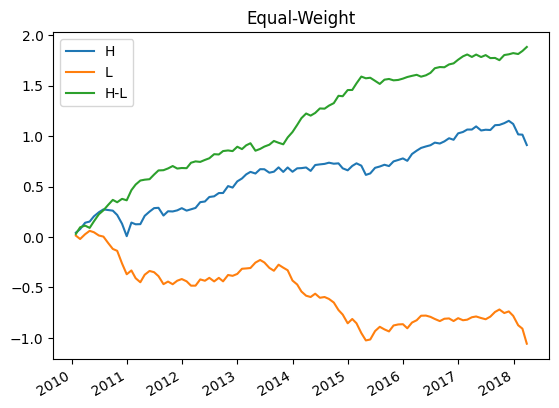

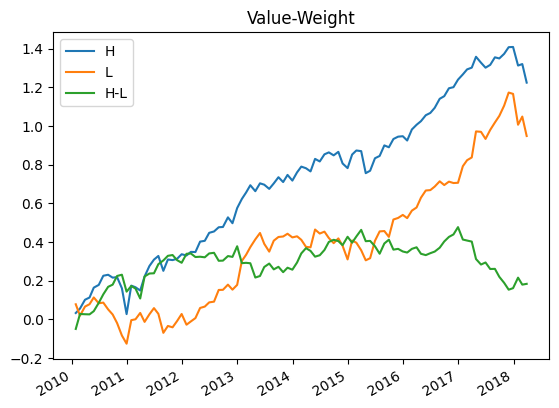

In [38]:
# Equal-weight
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['H'] = np.log((1 + r_h_ew).cumprod())
cumret['L'] = np.log((1 + r_l_ew).cumprod())
cumret['H-L'] = np.log((1 + r_hl_ew).cumprod())

cumret.plot(title='Equal-Weight')

# Value-weight
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['H'] = np.log((1 + r_h_vw).cumprod())
cumret['L'] = np.log((1 + r_l_vw).cumprod())
cumret['H-L'] = np.log((1 + r_hl_vw).cumprod())

cumret.plot(title='Value-Weight')

### XGBoost

In [39]:
from xgboost import XGBClassifier, callback
from sklearn.model_selection import train_test_split

In [40]:
callbacks = [callback.EarlyStopping(rounds=2, save_best=True)]
model = XGBClassifier(n_estimators=10, objective='multi:softprob', num_class=10, 
                      eval_metric='mlogloss', callbacks=callbacks, reg_alpha=0, reg_lambda=0)

x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

model.fit(x_train2, y_train2, eval_set=[(x_val, y_val)], verbose=True)


[0]	validation_0-mlogloss:1.70390
[1]	validation_0-mlogloss:1.57779
[2]	validation_0-mlogloss:1.49395
[3]	validation_0-mlogloss:1.43454
[4]	validation_0-mlogloss:1.39123
[5]	validation_0-mlogloss:1.35873
[6]	validation_0-mlogloss:1.33426
[7]	validation_0-mlogloss:1.31543
[8]	validation_0-mlogloss:1.30034
[9]	validation_0-mlogloss:1.28878


XGBClassifier(base_score=None, booster=None,
              callbacks=[<xgboost.callback.EarlyStopping object at 0x7fe34902f190>],
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=10, n_jobs=None,
              num_class=10, num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
# evaluate the XGB model
# on train set
accuracy_train = model.score(x_train, y_train)
print(f'Train set accuracy = {accuracy_train}')

# on test set
accuracy_test = model.score(x_test, y_test)
print(f'Test set accuracy = {accuracy_test}')

Train set accuracy = 0.4723466088313893
Test set accuracy = 0.4393416045806808


Here, using XGBoost classifier, the accuracy is lowwered a bit for the test set.

### Portfolio returns

In [42]:
# 'H' and 'L' portfolio returns
r_h_ew = []; r_l_ew = []  # equal-weight 
r_h_vw = []; r_l_vw = []  # value-weight

# predict in each month during the test period
for m, test_m in test.groupby('date'):
    x_test_m = test_m[x_cols].values
    
    # Predict the return class
    y_pred = model.predict(x_test_m)
    test_m_h = test_m[y_pred == 0] # data of class 'overbought'
    test_m_l = test_m[y_pred == 6] # data of class 'oversold'
    
    rh = test_m_h['tgt_ret'] # returns of class 'overbought'
    rl = test_m_l['tgt_ret'] # returns of class 'oversold'

    # equal-weight
    # portfolio weights
    wh_ew = (1/len(rh) if len(rh) else 0) * np.ones_like(rh)
    wl_ew = (1/len(rl) if len(rl) else 0) * np.ones_like(rl)
    
    # portfolio return
    r_h_ew.append(np.matmul(wh_ew, rh))
    r_l_ew.append(np.matmul(wl_ew, rl))

    # value-weight
    # portfolio weights
    sizeh = np.exp(test_m_h['size'])
    sizel = np.exp(test_m_l['size'])
    wh_vw = sizeh/np.sum(sizeh)
    wl_vw = sizel/np.sum(sizel)

    # portfolio return
    r_h_vw.append(np.matmul(wh_vw, rh))
    r_l_vw.append(np.matmul(wl_vw, rl))
    

# Equal-weight long, short, and long-short portfolios
# list -> np.array
r_h_ew = np.array(r_h_ew)
r_l_ew = np.array(r_l_ew)

# long-short portfolio return
r_hl_ew = r_h_ew - r_l_ew 

# Value-weight long, short, and long-short portfolios
# list -> np.array
r_h_vw = np.array(r_h_vw)
r_l_vw = np.array(r_l_vw)

# long-short portfolio return
r_hl_vw = r_h_vw - r_l_vw

### Evaluate portfolio

In [43]:
# dataframe to store evaluation results
pftab = pd.DataFrame(0, index=['cum', 'mean', 'std', 'Sharpe', 'mdd'], columns=[])

pftab['EW_H'] = evaluate(r_h_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_HL'] = evaluate(r_hl_ew)

pftab['VW_H'] = evaluate(r_h_vw)
pftab['VW_L'] = evaluate(r_l_vw)
pftab['VW_HL'] = evaluate(r_hl_vw)

pftab

,EW_H,EW_L,EW_HL,VW_H,VW_L,VW_HL
cum,1.424259,-0.757597,7.916097,2.529959,0.389615,1.390832
mean,0.117817,-0.156596,0.274414,0.164376,0.051383,0.112993
std,0.140976,0.164939,0.113421,0.144844,0.151162,0.117406
Sharpe,0.835727,-0.949420,2.419429,1.134848,0.339922,0.962410
mdd,-0.241759,-0.769665,-0.072332,-0.202229,-0.312358,-0.124146


#Portfolio Performance

1. Cumulative return:
 Equal weight strategy results in a positive return of 691.61%
 Value weight strategy results in a positive return of  39.08%
2. Risk adjusted return:
Equal weight strategy stands out with the highest Sharpe ratio of 2.42, suggesting superior risk-adjusted returns.
3. MDD:
Equal weight strategy has the smallest MDD of -0.0723 (or -7.23%), suggesting relatively limited drawdowns compared to other strategy of investing.

### Cumulative return

<Axes: title={'center': 'Value-Weight'}>

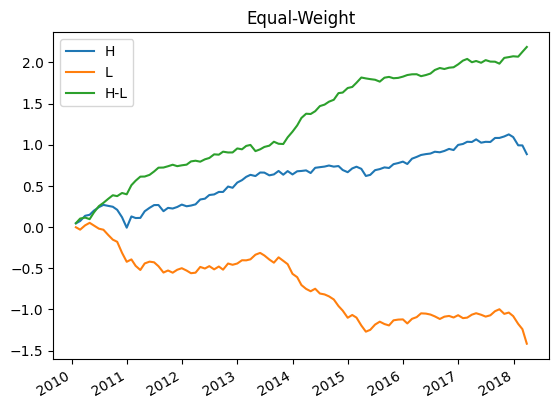

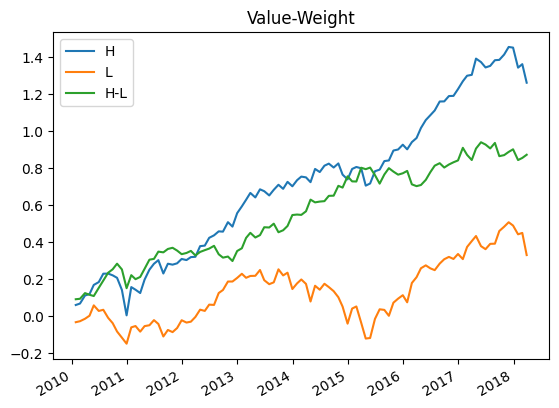

In [44]:
# Equal-weight
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['H'] = np.log((1 + r_h_ew).cumprod())
cumret['L'] = np.log((1 + r_l_ew).cumprod())
cumret['H-L'] = np.log((1 + r_hl_ew).cumprod())

cumret.plot(title='Equal-Weight')

# Value-weight
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['H'] = np.log((1 + r_h_vw).cumprod())
cumret['L'] = np.log((1 + r_l_vw).cumprod())
cumret['H-L'] = np.log((1 + r_hl_vw).cumprod())

cumret.plot(title='Value-Weight')

#Comments on the class

Overall, I really enjoy this summative assignment. It pushed me to learn more about different technical indicators for the stock market such as RSI and SMA. It also forced me to come up with my own way to apply the packages onto the dataframe (generating my own functions to calculate the variables). I must say I struggle a lot this part.

It also gave me a chance to create my own first model and to evaluate its performance. Although the accuracy is relatively low, I try to think that it is because we cannot beat the market. Furthermore, this assignment will be of great help for my CV in the future.

If there was anything I could change about the course, I wish that the first 3 weeks were taught by our professor instead of watching online lectures. Although the online lectures are splendid and the lecturer is also extremely influential in the field, I believe that learning the very foundation of ML offline will help the students focus more in class and understand the concepts better compared to watching online lectures.

Thank you professor!